In [1]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False
from scipy.stats import chi2

## Data Import

In [2]:
mat = scipy.io.loadmat('Data/hw6data.mat')

In [3]:
cov = mat['Q']
mu = mat['mu'].reshape(-1)
rtn_series = mat['R']

In [4]:
sample_mean = np.mean(rtn_series,axis = 1)
sample_cov = np.cov(rtn_series)

In [5]:
sigma = np.diag(np.diag(cov/len(rtn_series[0])))

In [87]:
#Parameter Setting
k_list = np.arange(0.05, 0.25, 0.05)
iter_num = 200
t_list = [0.5, 1, 5, 10, 50]
#a_list = [0.01, 0.1, 1, 10, 50, 100]

## Sensitivity Analysis

### Traditional Markovitz Optimization

In [88]:
def Markovitz_basic_portfolio(mean, cov, t):
    N = len(mean)
    a = 2/t
    
    P = matrix(a*cov)
    q = matrix((-1)*mean)
    G = matrix(np.diag([-1.0 for i in range(N)]), tc='d')
    h = matrix(np.array([0.0 for i in range(N)]), tc='d')
    A = matrix(np.array([[1.0 for i in range(N)]]), tc='d')
    b = matrix(np.array([1.0]), tc='d')
    sol = solvers.qp(P,q,G,h,A,b)
    w = sol['x']
    CE_0 = -sol['primal objective']
    return w, CE_0

In [125]:
def Markovitz_sensitivity_analysis(mean, cov, t, k, objective):
    N = len(mean)
    a = 2/t
    
    if objective == 'mean':
        z = np.random.normal(size = N)*k + 1
        mean_new = np.multiply(mean, z)
        P = matrix(a*cov)
        q = matrix((-1)*mean_new)
    elif objective == 'variance':
        flag = 0
        while flag == 0:
            z = np.random.normal(size = N)*k + 1
            var = np.diag(cov)
            var_new = np.multiply(var, z)
            cov_new = cov + np.diag(var_new - var)
            flag = np.all(np.linalg.eigvals(cov_new) > 0)
        P = matrix(a*cov_new)
        q = matrix((-1)*mean)
    elif objective == 'covariance':
        flag = 0
        while flag == 0:
            z = np.random.normal(size = N**2)*k + 1
            var = np.diag(cov)
            upper = np.triu(cov)
            cov_new = np.multiply(upper.reshape(-1), z).reshape((N,N))
            cov_new += cov_new.T
            cov_new = cov_new - np.diag(np.diag(cov_new)) + np.diag(var)
            flag = np.all(np.linalg.eigvals(cov_new) > 0)
        P = matrix(a*cov_new)
        q = matrix((-1)*mean)
    
    G = matrix(np.diag([-1.0 for i in range(N)]), tc='d')
    h = matrix(np.array([0.0 for i in range(N)]), tc='d')
    A = matrix(np.array([[1.0 for i in range(N)]]), tc='d')
    b = matrix(np.array([1.0]), tc='d')

    sol = solvers.qp(P,q,G,h,A,b)
    w_new = sol['x']
    CE_x = np.dot(mean,w_new)[0] - 0.5*a*np.dot(np.dot(w_new.T, cov), w_new)[0][0]
    return CE_x

In [126]:
MV_mean_CEL = pd.DataFrame(data = None, index = k_list, columns = t_list)
MV_variance_CEL = pd.DataFrame(data = None, index = k_list, columns = t_list)
MV_covariance_CEL = pd.DataFrame(data = None, index = k_list, columns = t_list)

In [127]:
for t in t_list:
    w0, CE_0 = Markovitz_basic_portfolio(sample_mean, sample_cov, t)
    for k in k_list:
        CEL = 0
        for i in range(iter_num):
            CE_x = Markovitz_sensitivity_analysis(sample_mean, sample_cov, t, k, 'mean')
            CEL += (1 - CE_x/CE_0)
        CEL /= iter_num
        MV_mean_CEL.loc[k, t] = CEL

In [128]:
for t in t_list:
    w0, CE_0 = Markovitz_basic_portfolio(sample_mean, sample_cov, t)
    for k in k_list:
        CEL = 0
        for i in range(iter_num):
            CE_x = Markovitz_sensitivity_analysis(sample_mean, sample_cov, t, k, 'variance')
            CEL += (1 - CE_x/CE_0)
        CEL /= iter_num
        MV_variance_CEL.loc[k, t] = CEL

In [129]:
for t in t_list:
    w0, CE_0 = Markovitz_basic_portfolio(sample_mean, sample_cov, t)
    for k in k_list:
        CEL = 0
        for i in range(iter_num):
            CE_x = Markovitz_sensitivity_analysis(sample_mean, sample_cov, t, k, 'covariance')
            CEL += (1 - CE_x/CE_0)
        CEL /= iter_num
        MV_covariance_CEL.loc[k, t] = CEL

In [130]:
with pd.ExcelWriter('Data/Results/Effects of Errors.xlsx') as writer: 
    MV_mean_CEL.to_excel(writer, sheet_name = 'Mean')
    MV_variance_CEL.to_excel(writer, sheet_name = 'Variance')
    MV_covariance_CEL.to_excel(writer, sheet_name = 'Covariance')

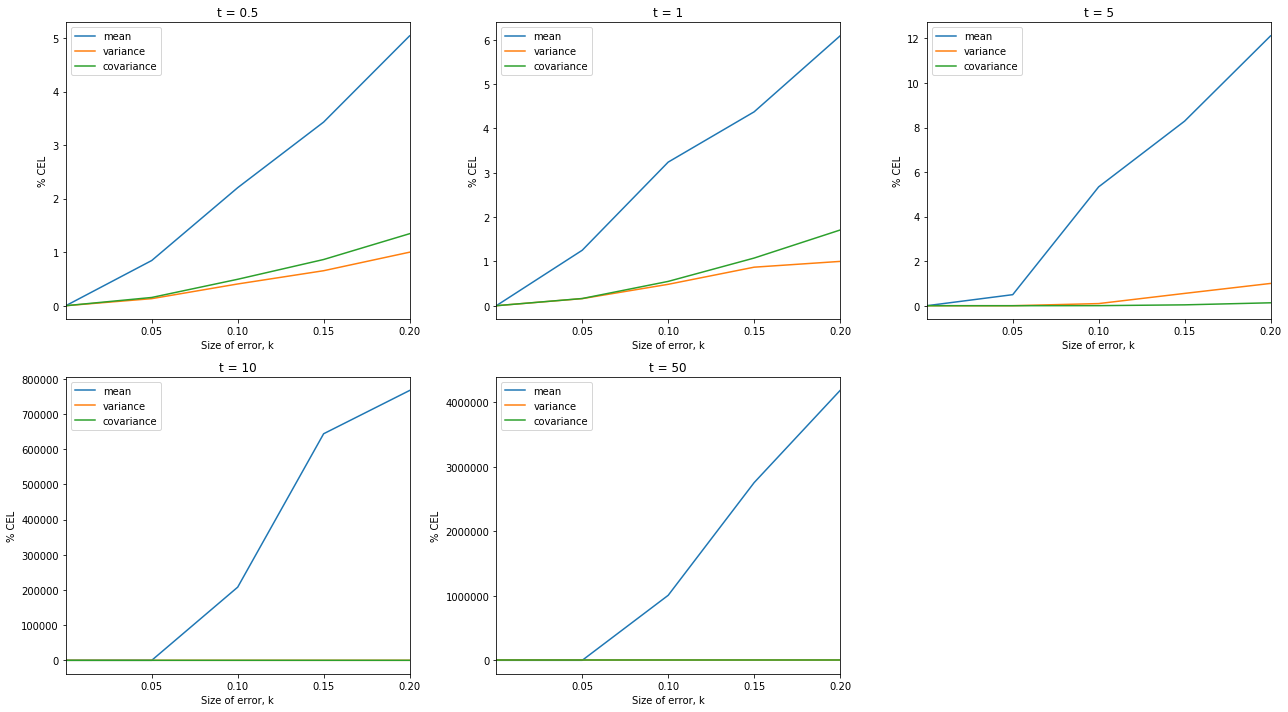

In [131]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (18,10))
for i in range(len(t_list)):
    df = pd.DataFrame(MV_mean_CEL.iloc[:,i]).join(MV_variance_CEL.iloc[:,i], rsuffix = 'var').join(MV_covariance_CEL.iloc[:,i], rsuffix = '_cov')
    df.columns = ['mean','variance','covariance']
    df.loc[0,:] = 0.0
    df = df.sort_index()
    df = df/df.iloc[4,1]
    r = i//3
    c = i%3
    ax0 = df.plot(title = 't = '+str(t_list[i]), ax = axes[r,c], xticks = [0]+k_list)
    ax0.set_xlabel('Size of error, k')
    ax0.set_ylabel('% CEL')
fig.tight_layout()
fig.delaxes(axes[1][2])
plt.savefig('Graph/Average CEL.png')

### Robust Optimization 

In [79]:
def Robust_portfolio(mean, cov, sigma, t, eta):
    N = len(mean)
    a = 2/t
    kappa = np.sqrt(chi2.ppf(eta, df = N))
    L = np.linalg.cholesky(sigma)
    
    P_0 = np.hstack([a*cov, np.array([[0.0] for i in range(N)])])
    P_0 = np.vstack([P_0, np.array([0.0 for i in range(N+1)])])
    P = matrix(P_0)
    
    q = matrix(np.append((-1)*mean, [kappa]))
    
    
    A = matrix(np.array([[1.0 for i in range(N)] + [0.0]]), tc='d')
    b = matrix(np.array([1.0]), tc='d')
    
    I = matrix(0.0, (N+1,N+1))
    I[::N+2] = 1.0
    G_1 = np.hstack([(-1)*L, np.array([[0.0] for i in range(N)])])
    G_1 = np.vstack([np.array([0.0 for i in range(N)] + [-1.0]), G_1])
    G = matrix([-I, matrix(G_1)])
    h = matrix((N+1)*[0.0] + (N+1)*[0.0])
    
    dims = {'l': N+1, 'q': [N+1], 's': []}
    
    sol = solvers.coneqp(P, q, G, h, dims, A, b)
    w = sol['x'][:-1]
    CE_0 = np.dot(mean,w)[0] - 0.5*a*np.dot(np.dot(w.T, cov), w)[0][0]
    
    return w, CE_0

In [80]:
def Robust_sensitivity_analysis(mean, cov, sigma, t, k, eta, objective):
    N = len(mean)
    a = 2/t
    kappa = np.sqrt(chi2.ppf(eta, df = N))
    L = np.linalg.cholesky(sigma)
    
    if objective == 'mean':
        z = np.random.normal(size = N)*k + 1
        mean_new = np.multiply(mean, z)
        P_0 = np.hstack([a*cov, np.array([[0.0] for i in range(N)])])
        P_0 = np.vstack([P_0, np.array([0.0 for i in range(N+1)])])
        P = matrix(P_0)
    
        q = matrix(np.append((-1)*mean_new, [kappa]))
    
    
    A = matrix(np.array([[1.0 for i in range(N)] + [0.0]]), tc='d')
    b = matrix(np.array([1.0]), tc='d')
    
    I = matrix(0.0, (N+1,N+1))
    I[::N+2] = 1.0
    G_1 = np.hstack([(-1)*L.T, np.array([[0.0] for i in range(N)])])
    G_1 = np.vstack([np.array([0.0 for i in range(N)] + [-1.0]), G_1])
    G = matrix([-I, matrix(G_1)])
    h = matrix((N+1)*[0.0] + (N+1)*[0.0])
    
    dims = {'l': N+1, 'q': [N+1], 's': []}
    
    sol = solvers.coneqp(P, q, G, h, dims, A, b)
    w = sol['x'][:-1]
    CE_x = np.dot(mean,w)[0] - 0.5*a*np.dot(np.dot(w.T, cov), w)[0][0]
    
    return w, CE_x

In [81]:
Robust_mean_CEL = pd.DataFrame(data = None, index = k_list, columns = t_list)

In [82]:
for t in t_list:
    w_r, CE_r_0 = Robust_portfolio(sample_mean, cov, sigma, t, eta = 0.95)
    for k in k_list:
        CEL_r = 0
        for i in range(iter_num):
            w_r_x, CE_r_x = Robust_sensitivity_analysis(sample_mean, cov, sigma, t, k, eta = 0.95, objective = 'mean')
            CEL_r += (1 - CE_r_x/CE_r_0)
        CEL_r /= iter_num
        Robust_mean_CEL.loc[k, t] = CEL_r